import libs

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential

In [10]:
# def get_strategy():
#   # Detect hardware and configure parallel compute
#   try:
#       # Try to detect TPU
#       resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#       tf.config.experimental_connect_to_cluster(resolver)
#       tf.tpu.experimental.initialize_tpu_system(resolver)
#       strategy = tf.distribute.TPUStrategy(resolver)
#       print("TPU detected. Using TPU for parallel computation.")
#   except ValueError:
#       # If no TPU is found, check for GPU
#       if tf.config.list_physical_devices('GPU'):
#           print("No TPU detected. GPU detected. Using GPU for parallel computation.")
#           strategy = tf.distribute.MirroredStrategy()
#       else:
#           # If no GPU is found, fall back to CPU
#           print("No TPU or GPU detected. Using CPU for parallel computation.")
#           strategy = tf.distribute.MultiWorkerMirroredStrategy()
#   return strategy
# strategy = get_strategy()

Enable GPU parallel processing

In [11]:
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


load dataset

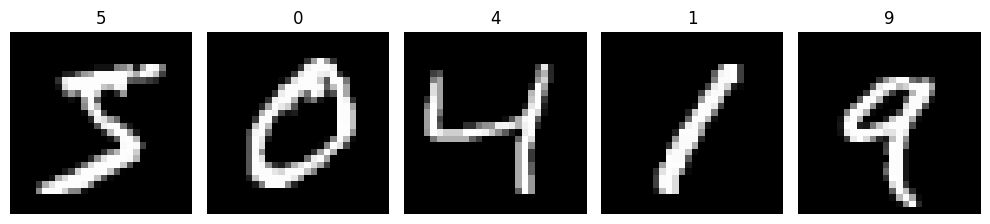

In [12]:
from keras.src.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Normalize, reshape to 28*28*1, one hot labeling the 10 classes

In [13]:
from keras.src.utils import to_categorical

x_train,x_test=x_train/255.0,x_test/255.0 # normalize
print(x_train.shape)
print(y_train)
x_train=x_train.reshape(-1,28,28,1) # reshape
x_test=x_test.reshape(-1,28,28,1)
y_train=to_categorical(y_train,10) # one hot labeling
y_test=to_categorical(y_test,10)
print(x_train.shape)
print(y_train)

(60000, 28, 28)
[5 0 4 ... 5 6 8]
(60000, 28, 28, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


Build CNN inside the stratege scope

In [14]:
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense

with strategy.scope():
    model=Sequential([
        Conv2D(32,(3,3),activation='relu', padding='same', input_shape=(28,28,1)), # strides=(2,2)
        MaxPooling2D((2,2)),
        Conv2D(64,(3,3),activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128,activation='relu'),
        Dense(10,activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Train model

In [15]:
model.fit(x_train,y_train,epochs=10,batch_size=128,validation_data=(x_test,y_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8718 - loss: 0.4368 - val_accuracy: 0.9822 - val_loss: 0.0546
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9818 - loss: 0.0576 - val_accuracy: 0.9876 - val_loss: 0.0359
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9888 - loss: 0.0371 - val_accuracy: 0.9888 - val_loss: 0.0354
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9920 - loss: 0.0251 - val_accuracy: 0.9903 - val_loss: 0.0265
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9943 - loss: 0.0181 - val_accuracy: 0.9894 - val_loss: 0.0323
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9947 - loss: 0.0167 - val_accuracy: 0.9885 - val_loss: 0.0357
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9955 - loss: 0.0134 - val_accuracy: 0.9912 - val_loss: 0.0294
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9971 - loss: 0.0086 - 

Evaluate model

In [16]:
loss, accuracy=model.evaluate(x_test,y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9888 - loss: 0.0358
Test loss: 0.031265173107385635
Test accuracy: 0.9908000230789185
